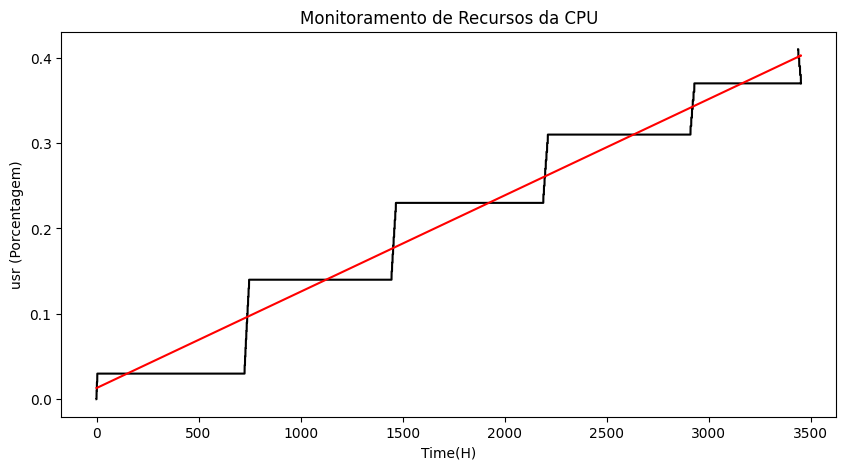

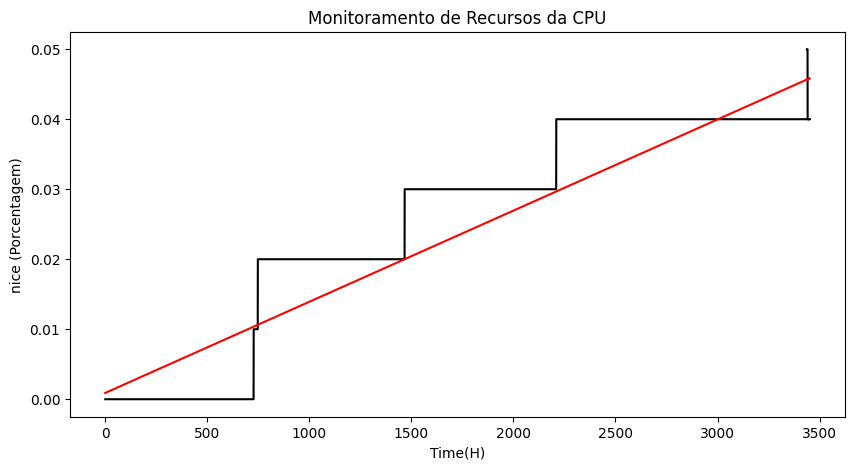

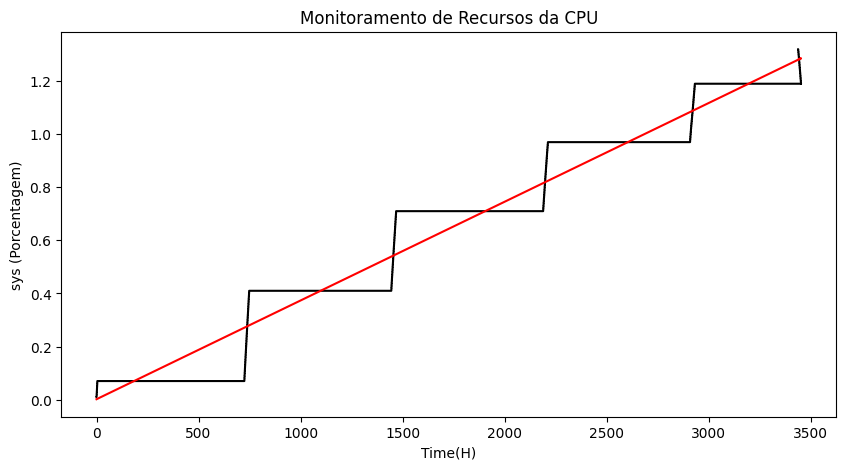

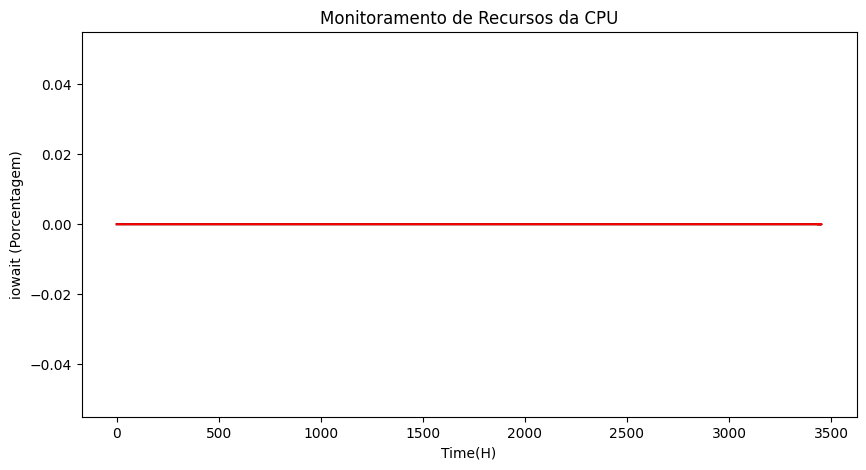

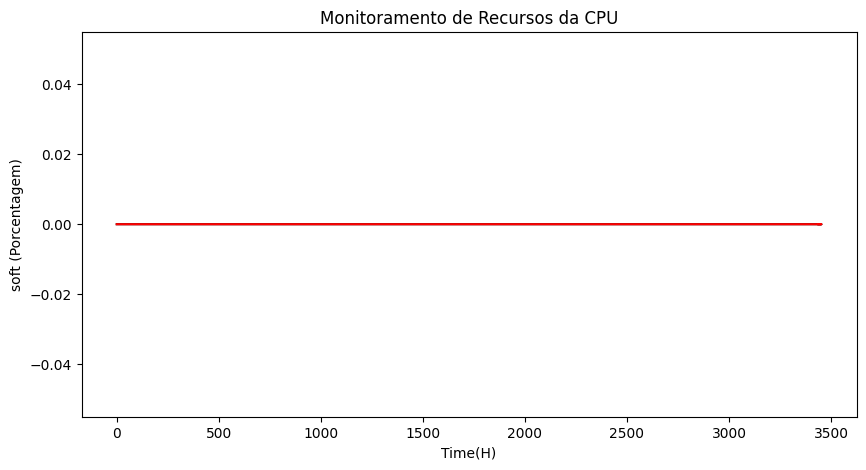

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

TIPO_VIRTUALIZADOR = '_kvm1G/logs_sem_erro_1GB'

# CAMINHO_ABSOLUTO = f'./data_logs/logs{TIPO_VIRTUALIZADOR}'
CAMINHO_ABSOLUTO = f'/content/drive/MyDrive/logs_todos/logs{TIPO_VIRTUALIZADOR}'


logs_gerais = {
    'machine_monitoring_cpu': f'{CAMINHO_ABSOLUTO}/machine_monitoring-cpu.csv',
    'machine_monitoring_zombies': f'{CAMINHO_ABSOLUTO}/machine_monitoring-zombies.csv',
    'machine_monitoring_mem': f'{CAMINHO_ABSOLUTO}/machine_monitoring-mem.csv',
    'machine_monitoring_disk': f'{CAMINHO_ABSOLUTO}/machine_monitoring-disk.csv',
    'machineHost_server_status': f'{CAMINHO_ABSOLUTO}/machineHost_server_status.csv',

    'response_times': f'{CAMINHO_ABSOLUTO}/response_times.csv',
    'reset_times': f'{CAMINHO_ABSOLUTO}/reset_times.csv'
}

logs_vbox = {
    'vbox_monitoring_VBoxHeadless': f'{CAMINHO_ABSOLUTO}/vbox_monitoring-VBoxHeadless.csv',
    'vbox_monitoring_VBoxSVC': f'{CAMINHO_ABSOLUTO}/vbox_monitoring-VBoxSVC.csv',
    'vbox_monitoring_VBoxXPCOMIPCD': f'{CAMINHO_ABSOLUTO}/vbox_monitoring-VBoxXPCOMIPCD.csv'
}

logs_kvm = {
    'kvm_Headless_monitoring': f'{CAMINHO_ABSOLUTO}/kvm_Headless_monitoring.csv',
    'kvm_libvirtd_service_monitoring': f'{CAMINHO_ABSOLUTO}/kvm_libvirtd_service_monitoring.csv'
}

logs_xen = {

}

logs_lxc = {

}

logs_fragmentacao = {
    'fragmentation': f'{CAMINHO_ABSOLUTO}/fragmentation.csv'
}





def carregar_data_frame(arquivo_caminho):
  return pd.read_csv(arquivo_caminho, sep=';')


def configurar_index_data_frame(data_frame):
  try:
      data_frame['date_time'] = pd.to_datetime(data_frame['date_time'], format='%d-%m-%Y-%H:%M:%S')

  except ValueError as e:
      # Imprima o erro e o valor problemático que está causando o erro
      print("Erro:", e)
      valor_problematico = data_frame.loc[data_frame['date_time'].str.match(r'\d{2}-\d{2}-\d{4}-\d{2}:\d{2}:\d{2}') == False, 'date_time'].iloc[0]
      print("Valor problemático:", valor_problematico)
      return data_frame

  # data_frame['date_time'] = pd.to_datetime(data_frame['date_time'], format='%d-%m-%Y-%H:%M:%S')
  data_frame_formatado_index = data_frame.set_index(data_frame['date_time'])

  data_frame_formatado_index['tempo_passado'] = data_frame_formatado_index['date_time'].dt.strftime('%H:%M:%S')
  data_frame_formatado_index['tempo_passado'] = abs(data_frame_formatado_index.index - data_frame_formatado_index.index[0]).total_seconds() / 3600

  data_frame_formatado_index = data_frame_formatado_index.set_index('tempo_passado')

  return data_frame_formatado_index



def formatar_tipo_coluna_data_frame(data_frame, nome_arquivo):
  data_frame_coluna_formatado_tipo = data_frame

  for coluna in data_frame.columns:
    if coluna != 'date_time' and coluna != 'tempo_passado' and data_frame_coluna_formatado_tipo[coluna].dtype == 'object':
      data_frame_coluna_formatado_tipo[coluna] = data_frame_coluna_formatado_tipo[coluna].str.replace(",", ".").astype(float)

  fazer_plot_regressao(data_frame_coluna_formatado_tipo, nome_arquivo, dividir_colunas=1)

  return data_frame_coluna_formatado_tipo




def fazer_plot_regressao(data_frame, nome_arquivo, dividir_colunas=0):
  incluirColunaY = True
  title = f'Monitoramento de Recursos de ({nome_arquivo})'

  if nome_arquivo in ['machine_monitoring_cpu', 'machine_monitoring_disk', 'machine_monitoring_mem']:
    tipoYlabel = '(porcentagem)'

  elif nome_arquivo in ['machine_monitoring_zombies', 'machineHost_server_status', 'reset_times']:
    tipoYlabel = '(number of occurrences)'

  elif nome_arquivo in 'response_times':
    tipoYlabel = '(mili seconds)'

  else:
    tipoYlabel = '(porcentagem)'


  if dividir_colunas == 1:
    for col in data_frame.columns:
      if type(tipoYlabel) is str and incluirColunaY is True:
        parte_coluna_df = f"{col} {tipoYlabel}"

      else:
        parte_coluna_df = f"{tipoYlabel}"

      if col != 'date_time':
        x = data_frame.index.values.reshape(-1, 1)
        y = data_frame[col].fillna(0)

        model = LinearRegression()
        model.fit(x, y)

        Y_pred = model.predict(x)

        if type(tipoYlabel) is str:
          ylabel = parte_coluna_df

        elif type(tipoYlabel) is dict and col in tipoYlabel:
          ylabel = ylabel[col]

        else:
          ylabel = col


        if type(title) is str:
          title = title

        elif type(title) is dict and col in title:
          title = title[col]

        else:
          title = col

        ax = data_frame.plot(
            title=title,
            figsize=(10, 5),
            legend=0,
            y=col,
            xlabel='Time(H)',
            ylabel=ylabel,
            style='k'
        )

        # Adicionar a linha da regressão
        ax.plot(x, Y_pred, color='red')

        # if os.path.exists(f}/{nome_arquivo}/'):
        #   pass

        # else:
        #     os.makedirs(f}/{nome_arquivo}/')

        # plt.savefig(f}/{nome_arquivo}/{nome_arquivo}_{col}.png')

        # plt.close()

        plt.show()




  else:
    # print('dividir coluna == 0')


    # Criar um único gráfico para todas as colunas do arquivo
    fig, ax = plt.subplots(figsize=(10, 5))
    styles = ['-', '--', '-.', ':']  # Estilos de linha diferentes

    for i, col in enumerate(data_frame.columns):
        if col != 'date_time':
            x = data_frame.index.values.reshape(-1, 1)
            y = data_frame[col].fillna(0)

            model = LinearRegression()
            model.fit(x, y)

            Y_pred = model.predict(x)

            ylabel = f"{col} {tipoYlabel}" if type(tipoYlabel) is str else tipoYlabel

            title = title if type(title) is str else title.get(col, col)

            ax.plot(data_frame.index, y, label=f'{col} (dados)', linestyle=styles[i % len(styles)], linewidth=7)  # Aumenta a espessura da linha

            ax.plot(data_frame.index, Y_pred, linestyle='--', color='black', linewidth=1, label=f'{col} (regressão)')  # Adiciona a linha de regressão com estilo padrão

    ax.set_title(title)
    ax.set_xlabel('Time(H)')
    ax.set_ylabel(ylabel)
    ax.legend()

    plt.show()

















def tipo_log(qual_log):
    if qual_log == 'vbox':
        return logs_vbox

    elif qual_log == 'kvm':
        return logs_kvm

    elif qual_log == 'xen':
        return logs_xen

    else:
        return logs_lxc


def monitoramentos_start():
    logs_tipo = tipo_log('kvm')

    for nome_arquivo, caminho_arquivo in logs_gerais.items():
        novo_data_frame = carregar_data_frame(caminho_arquivo)

        if novo_data_frame.empty:
            pass

        else:
            novo_data_frame = configurar_index_data_frame(novo_data_frame)
            novo_data_frame = formatar_tipo_coluna_data_frame(novo_data_frame, nome_arquivo)

    for nome_arquivo, caminho_arquivo in logs_tipo.items():
        novo_data_frame = carregar_data_frame(caminho_arquivo)

        if novo_data_frame.empty:
            pass

        else:
            novo_data_frame = configurar_index_data_frame(novo_data_frame)
            novo_data_frame = formatar_tipo_coluna_data_frame(novo_data_frame, nome_arquivo)

monitoramentos_start()